<a href="https://colab.research.google.com/github/Khojasteh-hb/MaskRCNN_Tumor_Detection/blob/main/MaskRCNN_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This code implements MaskRCNN for semantic segmentation of brain tumor. The backbone is pre-trained COCO dataset fine tuned on some annotated images.**

Section 1: This section ensures all the library version dependeices are met. Run the following cell and restart your run time.

Mask R-CNN - Train brain tumor Dataset

In [1]:
# First attach your google drive to the colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/drive/MyDrive/Colab Notebooks/MaskRCNN/')
!ls

brain_test	brain_train	 logs		    mrcnn
brain_test.rar	brain_train.rar  mask_rcnn_coco.h5


In [ ]:
!pip install -U scikit-image==0.16.2

In [4]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import pandas as pd

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

In [5]:
# # Data Path
TRAIN_PATH = './brain_train/'
TEST_PATH = './brain_test/'

# # Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

In [7]:
!pip uninstall h5py -y

Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0


In [ ]:
!pip install tensorflow==1.13.1
!pip install keras==2.0.8

In [ ]:
!pip install h5py==2.10.0

In [ ]:
import keras
keras.__version__

In [11]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

**Configurations**

In [12]:
class ShapesConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides values specific
    to the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 1 images per GPU. We can put multiple images on each
    # GPU. Batch size is (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + brain

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 64, 128, 256)  # anchor side in pixels

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 500

    # set number of epoch
    STEPS_PER_EPOCH = 200

    # set validation steps 
    VALIDATION_STEPS = 50
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

**Notebook Preferences**

In [13]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Dataset
Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, load_shapes(), and override the following methods:


*  load_image()
*  load_mask()
*   image_reference()

In [14]:
class ShapesDataset(utils.Dataset):
    
    def load_shapes(self, mode):
        
        # Add classes
        self.add_class("shapes", 1, "tumor")
        

        if mode == "train":  
            for n, id_ in enumerate(train_ids):
                if n < int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)
              
        if mode == "val":   
            for n, id_ in enumerate(train_ids):
                if n >= int(len(train_ids) * 0.9):
                    path = TRAIN_PATH + id_
                    img_path = path + '/images/'
                    self.add_image("shapes", image_id=id_, path=img_path)      

    def load_image(self, image_id):
        
        info = self.image_info[image_id]
        info = info.get("id")
       
        path = TRAIN_PATH + info
        img = imread(path + '/images/' + info + '.tif')[:,:,:3]
        img = resize(img, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
       
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        
        info = self.image_info[image_id]
        info = info.get("id")
        path = TRAIN_PATH + info
        number_of_masks = len(next(os.walk(path + '/masks/'))[2])
        mask = np.zeros([config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], number_of_masks], dtype=np.uint8)
        iterator = 0
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = resize(mask_, (config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1]), mode='constant', preserve_range=True)
            mask[:, :, iterator] = mask_
            iterator += 1
            # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(number_of_masks-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
            
        # Map class names to class IDs.
        class_ids = np.ones((number_of_masks,), dtype=int)
        
        return mask, class_ids.astype(np.int32)

In [15]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes("train")
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes("val")
dataset_val.prepare()

23 1 ['BG', 'tumor']


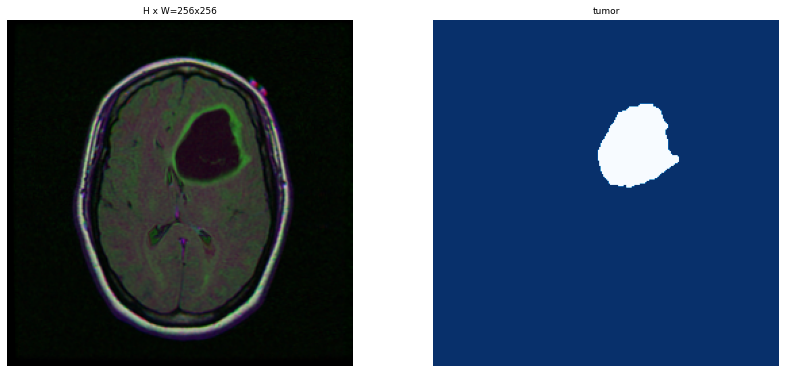

17 1 ['BG', 'tumor']


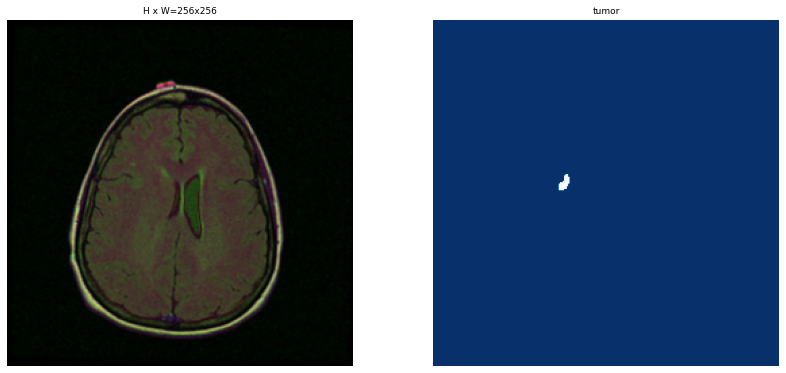

38 1 ['BG', 'tumor']


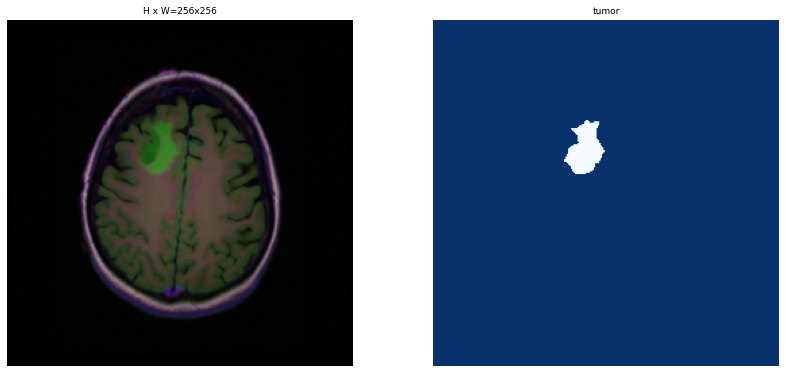

40 1 ['BG', 'tumor']


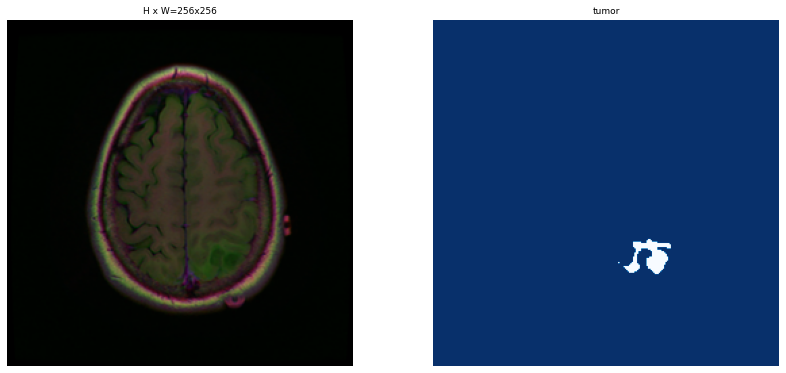

In [17]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image_id, len(class_ids),dataset_train.class_names)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit = 1)

Create Model

In [18]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [19]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

Training

Train in two stages:

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [20]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/MyDrive/Colab Notebooks/MaskRCNN/logs/shapes20220813T0639/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (T

Instructions for updating:
Use tf.cast instead.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
199/200 [============================>.] - ETA: 59s - loss: 1.9930 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.9003 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.6116 - mrcnn_mask_loss: 0.4438 

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


200/200 [==============================] - 12707s - loss: 1.9923 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.9004 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.6109 - mrcnn_mask_loss: 0.4436 - val_loss: 1.7500 - val_rpn_class_loss: 0.0142 - val_rpn_bbox_loss: 0.5965 - val_mrcnn_class_loss: 0.0234 - val_mrcnn_bbox_loss: 0.5955 - val_mrcnn_mask_loss: 0.5204


In [21]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
"""model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")"""

'model.train(dataset_train, dataset_val, \n            learning_rate=config.LEARNING_RATE / 10,\n            epochs=2, \n            layers="all")'

In [22]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
model.keras_model.save_weights(model_path)

**Detection**

In [23]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes4.h5")
#model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.


Loading weights from  /content/drive/MyDrive/Colab Notebooks/MaskRCNN/logs/mask_rcnn_shapes4.h5


original_image           shape: (256, 256, 3)         min:    0.00000  max:  243.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   58.00000  max:  183.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:  255.00000  uint8


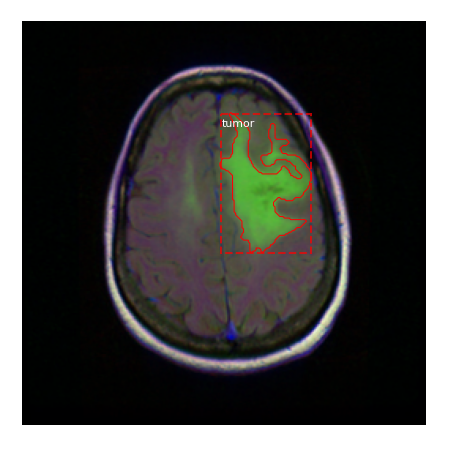

In [24]:
# Test on a random image
image_id = 1 #random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

original_image           shape: (256, 256, 3)         min:    0.00000  max:  223.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  int64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   62.00000  max:  197.00000  int32
gt_mask                  shape: (256, 256, 1)         min:    0.00000  max:  255.00000  uint8


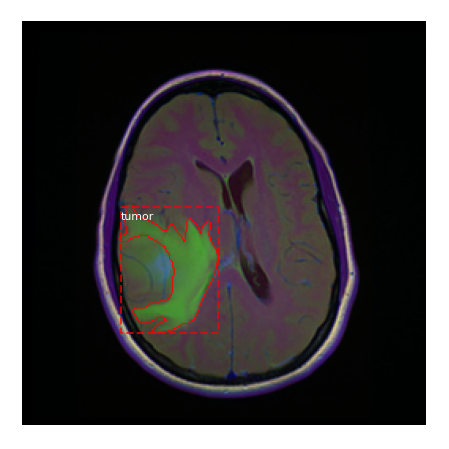

In [36]:
# Test on a random image
image_id = 4 #random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))